<a href="https://colab.research.google.com/github/Tamerstito/vhs_intro_cleaned/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.datasets import mnist

keras.datasets.mnist.load_data(path="mnist.npz")  # our dataset

# Raw 28×28 grayscale images
(x_train_raw, y_train), (x_test_raw, y_test) = keras.datasets.mnist.load_data()

# Scale to [0, 1] (Normalization)
x_train_raw = x_train_raw.astype("float32") / 255.0
x_test_raw  = x_test_raw.astype("float32")  / 255.0

x_train_flat = x_train_raw.reshape(-1, 28 * 28)        # (60000, 784)
x_test_flat  = x_test_raw.reshape(-1, 28 * 28)         # (10000, 784)

x_train_cnn  = x_train_raw[..., np.newaxis]            # (60000, 28, 28, 1)
x_test_cnn   = x_test_raw[..., np.newaxis]             # (10000, 28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
print("flat input  :", x_train_flat.shape)
print("cnn  input  :", x_train_cnn.shape)

flat input  : (60000, 784)
cnn  input  : (60000, 28, 28, 1)


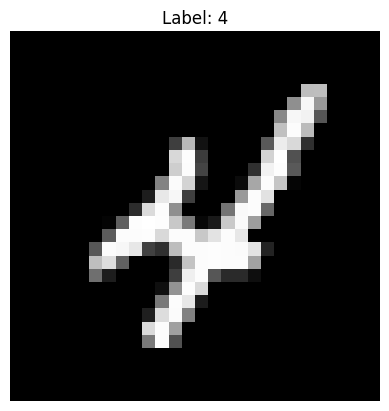

In [19]:
import matplotlib.pyplot as plt

idx = 9
plt.imshow(x_train_raw[idx], cmap='gray')
plt.title(f"Label: {y_train[idx]}")
plt.axis('off')
plt.show()


In [4]:
import numpy as np
unique_classes, counts = np.unique(y_train, return_counts=True) # receiving inputs for the classes and amounf of respective pixels/images for each class (0-9)
print("Classes:", unique_classes)
print("Counts:", counts)

Classes: [0 1 2 3 4 5 6 7 8 9]
Counts: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [6]:
from tensorflow import keras
from tensorflow.keras import layers

model_NN = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(28 * 28,)),  # <‑‑ tuple here
    layers.Dense(128, activation='relu'),
    layers.Dense(64,  activation='relu'),
    layers.Dense(10,  activation='softmax'),
])

In [10]:
# defining a train model function

def train_model(model, x_train, y_train, x_test,  y_test, optimizer='adam',
                epochs=10, batch_size=32):
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history

In [11]:
# Train Each Model

# Dense NN — Adam
history_NN_adam = train_model(
    model_NN,
    x_train_flat, y_train,
    x_test_flat,  y_test,
    optimizer='adam'
)
model_NN.save_weights('mnist_nn.weights.h5')              # saving the weights

# Dense NN — SGD
model_NN_sgd   = keras.models.clone_model(model_NN)       # new copy
history_NN_sgd = train_model(
    model_NN_sgd,
    x_train_flat, y_train,
    x_test_flat,  y_test,
    optimizer='sgd'
)
model_NN_sgd.save_weights('mnist_nn_sgd.weights.h5')      # saving the weights


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9955 - loss: 0.0153 - val_accuracy: 0.9792 - val_loss: 0.1046
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9957 - loss: 0.0161 - val_accuracy: 0.9780 - val_loss: 0.1048
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9966 - loss: 0.0114 - val_accuracy: 0.9780 - val_loss: 0.1049
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9968 - loss: 0.0090 - val_accuracy: 0.9788 - val_loss: 0.1184
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9969 - loss: 0.0103 - val_accuracy: 0.9797 - val_loss: 0.1181
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9969 - loss: 0.0094 - val_accuracy: 0.9794 - val_loss: 0.1193
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9970 - loss: 0.0092 - val_accuracy: 0.9773 - val_loss: 0.1257
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9976 - loss: 0

In [ ]:
# Converting the histories to DataFrames

history_df_NN_adam = pd.DataFrame(history_NN_adam.history)
history_df_NN_sgd = pd.DataFrame(history_NN_sgd.history)

In [22]:
# CNN Model — Adam
model_CNN = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax')
])

In [18]:
model_CNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,480 (408.13 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,654 (272.09 KB)

In [16]:
model_CNN.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
history_CNN_adam = model_CNN.fit(
    x_train_cnn, y_train,
    validation_data=(x_test_cnn, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

model_CNN.save_weights('mnist_cnn.weights.h5')

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - accuracy: 0.8693 - loss: 0.4310 - val_accuracy: 0.9806 - val_loss: 0.0628
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - accuracy: 0.9742 - loss: 0.0840 - val_accuracy: 0.9839 - val_loss: 0.0443
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 31ms/step - accuracy: 0.9794 - loss: 0.0650 - val_accuracy: 0.9877 - val_loss: 0.0368
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9819 - loss: 0.0546 - val_accuracy: 0.9886 - val_loss: 0.0335
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9854 - loss: 0.0451 - val_accuracy: 0.9902 - val_loss: 0.0291
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.9879 - loss: 0.0408 - val_accuracy: 0.9900 - val_loss: 0.0291
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.9875 - loss: 0.0392 - val_accuracy: 0.9906 - val_loss: 0.0266
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 31ms/step - accuracy: 0.9884 -

In [25]:
# Loading the saved weights — So I don't need to rerun all the models again.
from tensorflow import keras
from tensorflow.keras import layers

# Dense NN — Adam
dense_NN_adam_reload = keras.Sequential([
    keras.Input(shape=(28 * 28,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64,  activation='relu'),
    layers.Dense(10,  activation='softmax'),
])

# Loading the saved weights
dense_NN_adam_reload.load_weights('mnist_nn.weights.h5')

# compile and evaluate
dense_NN_adam_reload.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

loss_adam, acc_adam = dense_NN_adam_reload.evaluate(x_test_flat, y_test, verbose=0)
print(f"Dense‑NN (Adam, reloaded)  test accuracy: {acc_adam:.4f} — loss: {loss_adam:.4f}")

Dense‑NN (Adam, reloaded)  test accuracy: 0.9814 — loss: 0.1031


In [21]:
# Dense NN — SGD
dense_NN_sgd_reload = keras.Sequential([
    keras.Input(shape=(28 * 28,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64,  activation='relu'),
    layers.Dense(10,  activation='softmax'),
])

# Loading the saved weights
dense_NN_sgd_reload.load_weights('mnist_nn_sgd.weights.h5')

# compile and evaluate
dense_NN_sgd_reload.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

loss_sgd, acc_sgd = dense_NN_sgd_reload.evaluate(x_test_flat, y_test, verbose=0)
print(f"Dense‑NN (SGD, reloaded)  test accuracy: {acc_sgd:.4f} — loss: {loss_sgd:.4f}")

Dense‑NN (SGD, reloaded)  test accuracy: 0.9724 — loss: 0.0922


In [24]:
# CNN Model — Adam
cnn_reload = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

# Loading the saved weights
cnn_reload.load_weights('mnist_cnn.weights.h5')

# compile and evaluate
cnn_reload.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

loss_cnn, acc_cnn = cnn_reload.evaluate(x_test_cnn, y_test, verbose=0)
print(f"CNN (reloaded)            test accuracy: {acc_cnn:.4f} — loss: {loss_cnn:.4f}")

CNN (reloaded)            test accuracy: 0.9907 — loss: 0.0287


## Data handling
*   Dense networks (Adam & SGD) flatten every 28 x 28 image to a 784-element vector, so spatial relationships are lost before the first weight is applied.
*   CNN keeps the 28 x 28 grid (with a single-channel depth of 1).  Convolution layers therefore operate on small local windows and retain neighbourhood information.

## Parameter sharing and parameter count
*   Dense (Adam) - no sharing; every connection has its own weight  
Total trainable parameters: ≈ 242k
*   Dense (SGD) - identical architecture, therefore identical parameter behaviour  
Total trainable parameters: ≈ 242 k
*   CNN - each 3 x 3 filter is reused across all spatial positions, so a single set of nine weights serves the entire image  
Total trainable parameters: 34,826

*(The dense count is the sum of 784 x 256 + 256, 256 x 128 + 128, 128 x 64 + 64, and 64 x 10 + 10 = 242,762.)*

## Training time (Colab GPU, 10 epochs)
*   Dense nets: ~12 - 22s/epoch.
*   CNN: ~60 - 85s/epoch.

The longer CNN epochs reflect the heavier convolution operations even though the parameter set is much smaller. Additionally, the difference in time added up a lot, resulting in me having to wait a lot more for the CNN - 15 minutes as opposed to 1 minute and a half for the Dense nets. This extra time could add up if you are using a larger dataset or running a larger model making it a downside that should be heavily considered depending on the use case and the magnitude of the improvement (cost vs improvement). If the improvement isn't enough to warrant the extra time spent it may not be suitable for your implementation. It wasn't too bad for this implementation but regardless it was a very noticeable time difference as compared with the other networks.

## Accuracy and loss (reloaded weights)

Table of results:

| Model        | **Validation accuracy** | **Validation loss** | **Test accuracy**  | **Test loss** |
| ------------ | ----------------------- | ------------------- | ------------------ | ------------- |
| Dense - Adam | **0.980 ≈ 98.0%**      | 0.105               | **0.981 ≈ 98.1%** | 0.103         |
| Dense - SGD  | 0.970 ≈ 97.0%          | 0.095               | 0.972 ≈ 97.2%     | 0.092         |
| CNN          | **0.991 ≈ 99.1%**      | 0.031               | **0.991 ≈ 99.1%** | 0.029         |

I took the validation figures from the final epoch of each training run. The dense network trained with Adam reaches just under 98% validation accuracy (loss a little above 0.10) and 98.1% on the test set. When the same architecture uses plain SGD, validation accuracy is about 97% and test accuracy about 97.2%, with losses in the low-0.09 range (roughly a 1% dip because SGD's fixed step size learns more slowly in the ten-epoch window). The CNN keeps the 28 x 28 grid intact and hits about 99% on both validation and test, with loss around 0.03. The tiny gap between its validation and test scores shows it is generalising rather than memorising. Optimiser choice (Adam vs SGD) makes a noticeable difference inside the dense setup, but neither dense variant approaches the CNN's 99% accuracy or its much lower loss, even though the CNN has far fewer parameters.

## Take-away
Keeping the image structure intact and sharing kernel weights allows the CNN to generalise better with far fewer parameters, at the cost of higher per-epoch computation. Optimiser choice (Adam vs SGD) matters inside a given architecture, but it does not close the performance gap between a fully-connected network and a convolutional one on this task.
